In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers datasets librosa torchcodec tqdm soundfile -q

import os
import sys
import shutil
import numpy as np
import pandas as pd

import soundfile as sf
from tqdm.notebook import tqdm

from transformers import (
    ASTForAudioClassification,
    ASTFeatureExtractor,
    TrainingArguments,
    Trainer,
)

from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

src_folder = "/content/drive/MyDrive/Colab Notebooks/ETSP/data"
dst_folder = "/content/data_local"

if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

for dialect_folder in tqdm(os.listdir(src_folder), desc="Copying dialect folders", leave=True):
    src_dialect = os.path.join(src_folder, dialect_folder)
    dst_dialect = os.path.join(dst_folder, dialect_folder)
    if not os.path.exists(dst_dialect):
        os.makedirs(dst_dialect)

    audio_files = [f for f in os.listdir(src_dialect) if f.endswith('.wav')]
    for fname in tqdm(audio_files, desc=f"Copying {dialect_folder}", leave=False):
        shutil.copy2(os.path.join(src_dialect, fname), os.path.join(dst_dialect, fname))

audio_root = "/content/data_local"

Mounted at /content/drive


Copying dialect folders:   0%|          | 0/8 [00:00<?, ?it/s]

Copying lu:   0%|          | 0/2715 [00:00<?, ?it/s]

Copying ag:   0%|          | 0/2748 [00:00<?, ?it/s]

Copying bs:   0%|          | 0/2713 [00:00<?, ?it/s]

Copying gr:   0%|          | 0/2749 [00:00<?, ?it/s]

Copying be:   0%|          | 0/2700 [00:00<?, ?it/s]

Copying sg:   0%|          | 0/2752 [00:00<?, ?it/s]

Copying zh:   0%|          | 0/4065 [00:00<?, ?it/s]

Copying vs:   0%|          | 0/2753 [00:00<?, ?it/s]

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

sys.path.append('/content/drive/MyDrive/Colab Notebooks/ETSP/utils')
from prepare_dataset import make_datasets, make_audio_splits

file_path = '/content/drive/MyDrive/Colab Notebooks/ETSP/sentences_ch_de_transcribed.json'
dialects = ['ch_sg', 'ch_be', 'ch_gr', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_ag', 'ch_lu']

_, _, _, dialect2label, train_ids, val_ids, test_ids = make_datasets(file_path, dialects)
train_audio_df, val_audio_df, test_audio_df = make_audio_splits(
    audio_root, dialects, dialect2label, train_ids, val_ids, test_ids
)

# optional sanity check
for i in range(10):
    path = train_audio_df.iloc[i]["audio_path"]
    try:
        data, sr = sf.read(path)
        print(f"{path}: OK, shape={data.shape}, sr={sr}")
    except Exception as e:
        print(f"ERROR with file {path}: {e}")

/content/data_local/sg/ch_sg_0000.wav: OK, shape=(111573,), sr=22050
/content/data_local/sg/ch_sg_0003.wav: OK, shape=(95800,), sr=22050
/content/data_local/sg/ch_sg_0004.wav: OK, shape=(220059,), sr=22050
/content/data_local/sg/ch_sg_0005.wav: OK, shape=(133983,), sr=22050
/content/data_local/sg/ch_sg_0008.wav: OK, shape=(169785,), sr=22050
/content/data_local/sg/ch_sg_0011.wav: OK, shape=(142002,), sr=22050
/content/data_local/sg/ch_sg_0012.wav: OK, shape=(195219,), sr=22050
/content/data_local/sg/ch_sg_0013.wav: OK, shape=(127449,), sr=22050
/content/data_local/sg/ch_sg_0014.wav: OK, shape=(109427,), sr=22050
/content/data_local/sg/ch_sg_0017.wav: OK, shape=(85591,), sr=22050


In [ ]:
train_dataset = Dataset.from_pandas(train_audio_df)
val_dataset   = Dataset.from_pandas(val_audio_df)
test_dataset  = Dataset.from_pandas(test_audio_df)


In [ ]:
import librosa

model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"

feature_extractor = ASTFeatureExtractor.from_pretrained(model_name)

target_sr = feature_extractor.sampling_rate  # typically 16000

target_duration_sec = 10.0
target_num_samples = int(target_duration_sec * target_sr)

def preprocess_batch(batch):
    audio_arrays = []
    for path in batch["audio_path"]:
        wav, sr = sf.read(path, dtype="float32")
        if sr != target_sr:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)

        # truncate / pad to 10 s
        if len(wav) > target_num_samples:
            wav = wav[:target_num_samples]
        else:
            pad_len = target_num_samples - len(wav)
            wav = np.pad(wav, (0, pad_len), mode="constant")

        audio_arrays.append(wav)

    feats = feature_extractor(
        audio_arrays,
        sampling_rate=target_sr,
        return_tensors=None,
        padding="longest",   # now they’re already equal length
    )

    return {
        "input_values": feats["input_values"],
        "labels": batch["label"],
    }



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
train_dataset = train_dataset.map(preprocess_batch, batched=True, remove_columns=train_dataset.column_names)
val_dataset   = val_dataset.map(preprocess_batch, batched=True, remove_columns=val_dataset.column_names)
test_dataset  = test_dataset.map(preprocess_batch, batched=True, remove_columns=test_dataset.column_names)

# set format for PyTorch
train_dataset.set_format(type="torch")
val_dataset.set_format(type="torch")
test_dataset.set_format(type="torch")

Map:   0%|          | 0/16176 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

In [ ]:
id2label = {v: k for k, v in dialect2label.items()}
label2id = {k: v for v, k in id2label.items()}

model = ASTForAudioClassification.from_pretrained(
    model_name,
    num_labels=len(dialects),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,   # new head for your labels
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    import torch
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = (preds == labels).mean()

    # macro F1 etc. if needed
    from sklearn.metrics import f1_score
    f1_macro = f1_score(labels, preds, average="macro")

    return {"accuracy": acc, "f1_macro": f1_macro}

In [ ]:
training_args = TrainingArguments(
    output_dir="./ast-swissdial-results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_num_workers=4,
    eval_strategy="epoch",
    num_train_epochs=3,
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs_ast",
    load_best_model_at_end=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.007800,0.026467,0.992095,0.992102
2,0.002900,0.000060,1.000000,1.000000
3,0.000000,0.000248,1.000000,1.000000


TrainOutput(global_step=3033, training_loss=0.02184958425815688, metrics={'train_runtime': 383.3226, 'train_samples_per_second': 126.598, 'train_steps_per_second': 7.912, 'total_flos': 3.2895417429440594e+18, 'train_loss': 0.02184958425815688, 'epoch': 3.0})

Test classification report:
              precision    recall  f1-score   support

       ch_sg       1.00      1.00      1.00       253
       ch_be       1.00      1.00      1.00       253
       ch_gr       1.00      1.00      1.00       253
       ch_zh       1.00      1.00      1.00       253
       ch_vs       1.00      1.00      1.00       253
       ch_bs       1.00      1.00      1.00       253
       ch_ag       1.00      1.00      1.00       253
       ch_lu       1.00      1.00      1.00       253

    accuracy                           1.00      2024
   macro avg       1.00      1.00      1.00      2024
weighted avg       1.00      1.00      1.00      2024



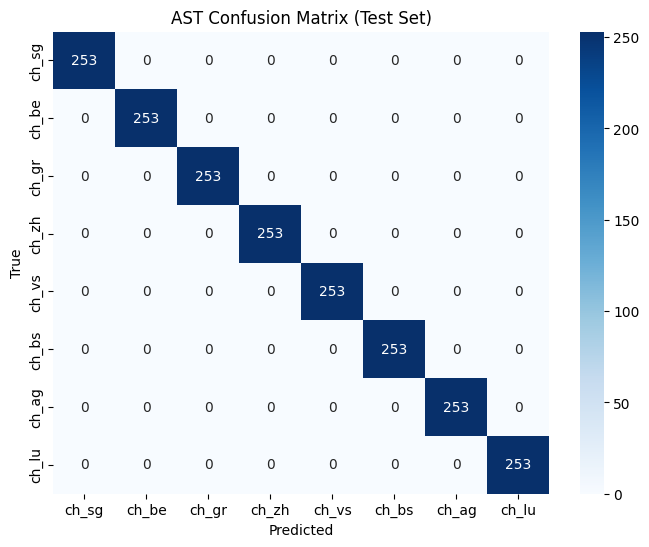

In [ ]:
preds = trainer.predict(test_dataset)
logits = preds.predictions
y_true = preds.label_ids
y_pred = np.argmax(logits, axis=-1)

print("Test classification report:")
print(classification_report(y_true, y_pred, target_names=dialects))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=dialects, yticklabels=dialects, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AST Confusion Matrix (Test Set)")
plt.show()